In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [3]:
import uscensus
from uscensus import SqlAlchemyCache

In [4]:
from configparser import RawConfigParser

In [5]:
cp = RawConfigParser()

In [6]:
cp.read('.census')

['.census']

In [7]:
import requests
s = requests.Session()

In [8]:
# Work around for some Windows TLS issues

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import ssl

class MyAdapter(HTTPAdapter):
    def init_poolmanager(self, connections, maxsize, block=False):
        self.poolmanager = PoolManager(num_pools=connections,
                                       maxsize=maxsize,
                                       block=block,
                                       ssl_version=ssl.PROTOCOL_TLSv1_2)
s.mount('https://', MyAdapter())

In [9]:
cache = SqlAlchemyCache('sqlite://')

In [10]:
%%time
with cache:
    cl = uscensus.DiscoveryInterface(
        cp.get('census','api_key'),
        cache,
        session=s,
    )

Error processing metadata; skipping API: {'c_isTimeseries': True, 'c_isCube': True, 'license': 'http://creativecommons.org/publicdomain/zero/1.0/Public Domain', 'modified': '2017-09-12', 'c_validValuesLink': 'https://api.census.gov/data/timeseries/poverty/histpov2/validValues.json', 'c_isAvailable': True, 'c_geographyLink': 'https://api.census.gov/data/timeseries/poverty/histpov2/geography.json', 'c_documentationLink': 'http://www.census.gov/developer/', 'contactPoint': {'fn': 'Current Population Survey Office', 'hasEmail': 'dsd.ferrett@census.gov'}, 'publisher': {'name': 'U.S. Census Bureau', '@type': 'org:Organization', 'subOrganizationOf': {'name': 'U.S. Department Of Commerce', '@type': 'org:Organization', 'subOrganizationOf': {'name': 'U.S. Government', '@type': 'org:Organization'}}}, 'accessLevel': 'public', 'references': ['http://www.census.gov/developers/'], 'distribution': [{'description': 'API endpoint', 'accessURL': 'https://api.census.gov/data/timeseries/poverty/histpov2', 

In [11]:
acs = cl.search('"acs 5-year detailed tables"')
acs

[ACS 5-Year Detailed Tables]

In [12]:
api = acs[0]
api

ACS 5-Year Detailed Tables

In [13]:
api.endpoint

'https://api.census.gov/data/2015/acs/acs5'

In [14]:
api.geographies

,scheme,name,predicate_type,referenceDate,requires,optionalWithWCFor,wildcard
0,fips,us,NaN,2015-01-01,NaN,NaN,NaN
1,fips,region,NaN,2015-01-01,NaN,NaN,NaN
2,fips,division,NaN,2015-01-01,NaN,NaN,NaN
3,fips,state,NaN,2015-01-01,NaN,NaN,NaN
4,fips,county,NaN,2015-01-01,[state],state,[state]
5,fips,county subdivision,NaN,2015-01-01,"[state, county]",county,[county]
6,fips,tract,NaN,2015-01-01,"[state, county]",county,[county]
7,fips,place,NaN,2015-01-01,[state],state,[state]
8,fips,alaska native regional corporation,NaN,2015-01-01,[state],state,[state]
9,fips,american indian area/alaska native area/hawaii...,NaN,2015-01-01,NaN,NaN,NaN


In [15]:
api.groups

{'B19101E': 'FAMILY INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE HOUSEHOLDER)',
 'B25129': 'TENURE BY YEAR HOUSEHOLDER MOVED INTO UNIT BY UNITS IN STRUCTURE',
 'B07404BPR': 'GEOGRAPHICAL MOBILITY IN THE PAST YEAR (BLACK OR AFRICAN AMERICAN ALONE) FOR RESIDENCE 1 YEAR AGO IN PUERTO RICO',
 'B992516': 'IMPUTATION OF RENT ASKED',
 'B08128': 'MEANS OF TRANSPORTATION TO WORK BY CLASS OF WORKER',
 'B19113G': 'MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (TWO OR MORE RACES)',
 'B19025A': 'AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER)',
 'C23002D': 'SEX BY AGE BY EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER (ASIAN ALONE)',
 'B992513': 'IMPUTATION OF TELEPHONE SERVICE AVAILABLE',
 'B11001E': 'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)',
 'B24082': 'SEX BY CLASS OF WORK

In [16]:
vars = api.searchVariables('"median gross rent"')
vars

,score,variable,group,concept,label,predicate_type
0,3.750000,B25064_001E,B25064,MEDIAN GROSS RENT (DOLLARS),Estimate!!Median gross rent,int
1,3.675000,B25031_001E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total,int
2,3.625000,B25031_002E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!No bedroom,int
3,3.589286,B25031_003E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!1 bedroom,int
4,3.589286,B25031_006E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!4 bedrooms,int
5,3.589286,B25031_007E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!5 or more ...,int
6,3.589286,B25031_004E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!2 bedrooms,int
7,3.589286,B25031_005E,B25031,MEDIAN GROSS RENT BY BEDROOMS,Estimate!!Median gross rent!!Total!!3 bedrooms,int
8,3.550000,B25111_001E,B25111,MEDIAN GROSS RENT BY YEAR STRUCTURE BUILT,Estimate!!Median gross rent!!Total,int
9,3.514286,B25113_001E,B25113,MEDIAN GROSS RENT BY YEAR HOUSEHOLDER MOVED IN...,Estimate!!Median gross rent!!Total,int


In [17]:
med_rent_by_county = api(['B25064_001E'], geo_for={'county': '*'})
med_rent_by_county.set_index(['state', 'county'], inplace=True)
med_rent_by_county.sort_index(inplace=True)
med_rent_by_county

B25064_001E
state county             
01    001           883.0
      003           879.0
      005           579.0
      007           651.0
      009           601.0
      011           570.0
      013           575.0
      015           637.0
      017           658.0
      019           621.0
      021           661.0
      023           497.0
      025           545.0
      027           451.0
      029           557.0
      031           683.0
      033           632.0
      035           522.0
      037           597.0
      039           599.0
      041           520.0
      043           625.0
      045           629.0
      047           564.0
      049           540.0
      051           785.0
      053           560.0
      055           621.0
      057           469.0
      059           534.0
...                   ...
72    095           345.0
      097           384.0
      099           420.0
      101           472.0
      103           418.0
      105           426.0
      107           350.0
      109           336.0
      111           401.0
      113           386.0
      115           450.0
      117           428.0
      119           531.0
      121           421.0
      123           371.0
      125           358.0
      127           466.0
      129           466.0
      131           363.0
      133           409.0
      135           582.0
      137           543.0
      139           543.0
      141           391.0
      143           503.0
      145           549.0
      147           590.0
      149           329.0
      151           419.0
      153           383.0

[3220 rows x 1 columns]

In [18]:
api.vintage

2015

In [19]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
import fiona
import geopandas as gpd
import shapely

In [21]:
%%time
# Generated in GetCountyShapes.ipynb
counties_df = gpd.GeoDataFrame.from_file('counties.geojson',
                                         driver='GeoJSON')
counties_df.crs = fiona.crs.from_epsg(4326)

Wall time: 56.1 s


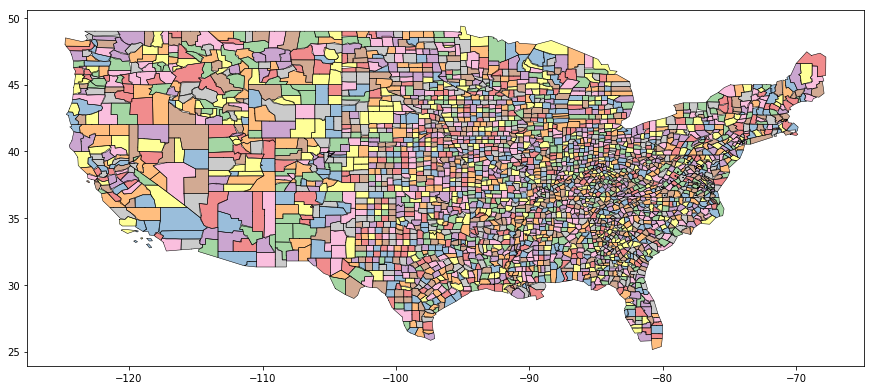

In [22]:
continental = shapely.geometry.box(-125.0011, 24.9493, -66.9326, 49.5904)
counties_df[counties_df.geometry.within(continental)].simplify(0.1).plot(
    figsize=((15,15)),
    linewidth=0.5)

In [23]:
%time
counties_df.set_index(['STATE', 'COUNTY'], inplace=True)
counties_df.sort_index(inplace=True)

Wall time: 0 ns


In [24]:
%time
counties_df.index.names=['state','county']
joined = counties_df.join(med_rent_by_county)

Wall time: 0 ns


In [25]:
#joined.total_bounds
continental = shapely.geometry.box(-125.0011, 24.9493, -66.9326, 49.5904)
joined_cont = joined[joined.intersects(continental)]

S:\programs\x64\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


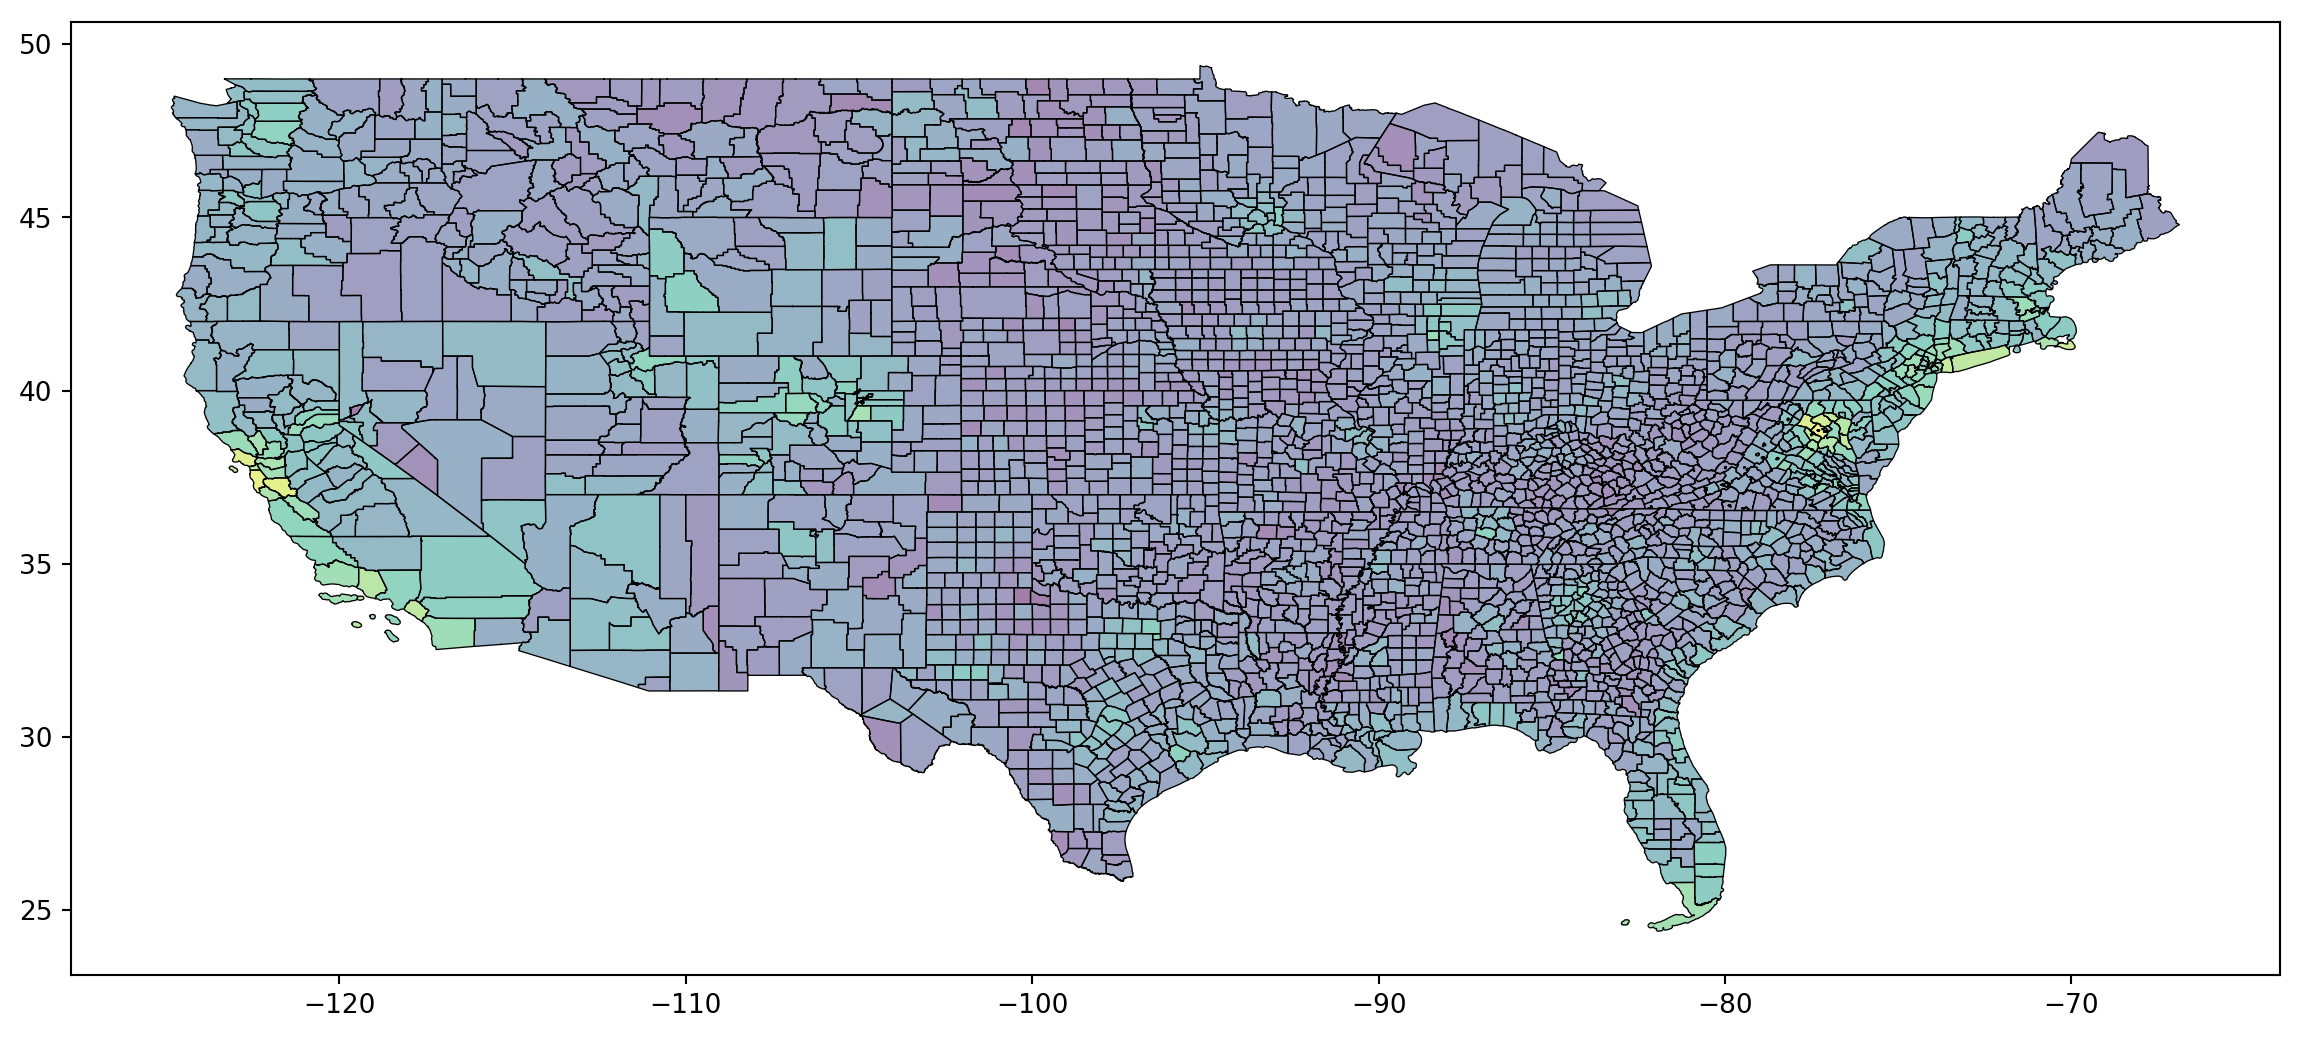

In [27]:
axes=joined_cont.plot(column='B25064_001E', 
                      figsize=(15,15),
                      linewidth=0.5)
axes.figure.dpi=190
axes

In [28]:
joined_cont.head()

BASENAME            NAME  \
state county                            
01    001     Autauga  Autauga County   
      003     Baldwin  Baldwin County   
      005     Barbour  Barbour County   
      007        Bibb     Bibb County   
      009      Blount   Blount County   

                                                       geometry  B25064_001E  
state county                                                                  
01    001     POLYGON ((-86.90309600018891 32.54062599981228...        883.0  
      003     POLYGON ((-87.99068399971394 30.55549000030206...        879.0  
      005     POLYGON ((-85.42981899962695 32.04598300002684...        579.0  
      007     POLYGON ((-87.31226499993386 33.08621900036046...        651.0  
      009     POLYGON ((-86.74918800009021 33.99759599972488...        601.0

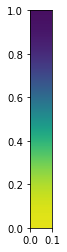

In [29]:
import matplotlib as mpl
import numpy as np
inc_min=joined_cont['B25064_001E'].min()
inc_max=joined_cont['B25064_001E'].max()
X = [[0, 0], [.9, .9]]
plt.gca().imshow(X, interpolation='bicubic', cmap=mpl.cm.get_cmap(),
          extent=(0, .1, 0, 1), alpha=1)